In [77]:
#%%
import os
import yaml
import torch
import argparse
import models
import numpy as np
from tqdm import tqdm
from datasets import MelDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# path
os.chdir('/mnt/work/')

# config path
data_config_path = "./Animal/configs/monkey/dataset.yaml"
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = MelDataset(dataset_config, used_key = ['twin_1', 'twin_2', 'twin_3', 'twin_4', 'twin_5'], subset='test')
analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# device
# torch.cuda.set_device(0)
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model loading 
model_config_path = "./Animal/configs/monkey/model.yaml"
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
exp_name = 'VAEbase-c_100.0_1.3-i_10.0_60.0'
model_path = 'Animal/output'
save_path = os.path.join(model_path, exp_name, 'checkpoint', "48000.pth.tar")
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi_mu = []
total_z_indi_log_std = []
total_z_indi = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, indi_mel, ctID, cID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        
        z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
        z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
        
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        total_z_indi_mu.append(z_indi_mu)
        total_z_indi_log_std.append(z_indi_log_std)
        total_z_indi.append(z_indi)
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        total_ctID.append(ctID.detach().cpu().numpy())
        total_cID.append(cID.detach().cpu().numpy())

100%|██████████| 14588/14588 [02:49<00:00, 86.28it/s] 


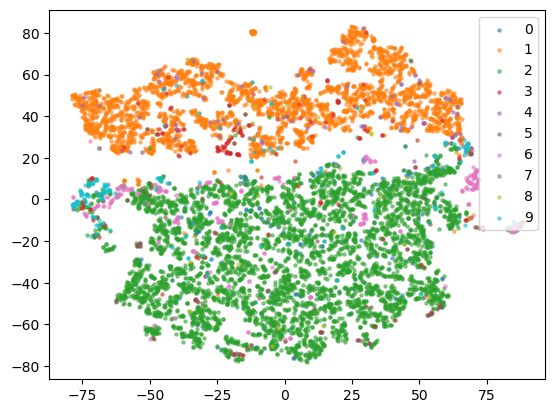

In [60]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_con_log_std: # content miu: total_z_con_mu content var: total_z_con_log_std
    total_z_con_1D.append(i.mean(2))
    
# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components=2, perplexity=30)

data_2d = tsne.fit_transform(total_z_con_1D) # cnontent

# Get unique labels
unique_labels = np.unique(total_ctID)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(total_ctID == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

# Add a legend
plt.legend()
plt.show()

In [51]:
total_z_indi

array([[ 0.139705  ,  0.68365353, -0.02307279, ..., -0.37897164,
        -0.66161597, -0.38210717],
       [ 0.7062785 , -0.9700744 , -1.325993  , ..., -0.314394  ,
        -0.41266724, -1.1384386 ],
       [-2.0897777 ,  0.16545793, -0.5237011 , ..., -0.93987894,
        -0.5328428 ,  0.8322729 ],
       ...,
       [-1.5338347 , -0.756443  ,  0.7202323 , ..., -0.83313704,
         0.4577703 ,  0.71355027],
       [-0.19465779,  0.04490761,  0.36918423, ...,  0.33365777,
         0.7174371 ,  0.9179059 ],
       [ 3.2319243 ,  0.07414283, -1.0410811 , ..., -0.18142506,
         1.2003481 ,  0.05689701]], dtype=float32)

In [65]:
total_con = np.hstack((total_z_indi_mu,total_z_indi_log_std))
total_con.shape

(8769, 256)

(1, 128, 77)

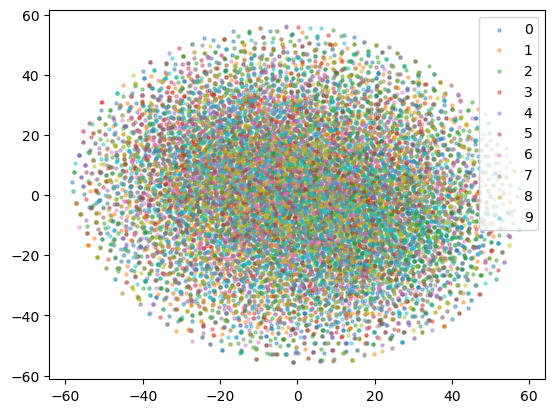

In [79]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi
total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()

total_indi = np.hstack((total_z_indi_mu,total_z_indi_log_std))

# tsne
tsne = TSNE(n_components=2, perplexity=30, n_iter=1500)
data_2d = tsne.fit_transform(total_z_indi)

# Get unique labels
unique_labels = np.unique(total_cID)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(total_cID == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.4, s=5)

# Add a legend
plt.legend()
plt.show()